# Dev Anomaly Pipeline 

This is a temporary notebook containing the developement of the anomaly detection pipeline

## To-do:
- Fix future warning 
- Plot forecasts only when enough data is present
- Add anomaly detection string to plot 
- Set reset capability of the pipeline for values that are stored (AverageModel)
- Find better way to produce live plots (maybe plotly)


## Packages

In [2]:
import datetime as dt
import pickle 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error

# Import project packages
from anomaly_detection.models import AverageModel
from anomaly_detection.preprocess import ImputeVals
from anomaly_detection.plotting import ForecastAllDayPlotter, ForecastPerWeekdayPlotter

## Constants

In [3]:
SEED=53456
CAMERA = '147'
MAX_MSE = 30
MIN_SAMPLES_PER_DAY = 350
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sample_period = '30min' #period to temporally aggregate the data
thresh_samples = 350 #minimum number of samples to consider a day

# setting up the paths
# data paths
cwd=os.getcwd()
root = os.path.dirname(cwd)
processed_image_dir = os.path.join(root, 'dat','processed_images')
image_folder = os.path.join(processed_image_dir,CAMERA,'2024-12-11')
output_folder = os.path.join(root, 'dat','output')
camera_dir = os.path.join(processed_image_dir, CAMERA)
tabular_csv_path = os.path.join(output_folder, 'traffic_147_two_way.csv')
plot_csv_path = os.path.join(output_folder, "plot_traffic_147.csv")
# model paths
run_dir = os.path.join(root, 'runs','detect')
best_weights_path  = os.path.join(run_dir, 'train15', 'weights','best.pt')
time_series_model_dir = os.path.join(root, 'dat', 'model', 'time_series_model')
average_model_path = os.path.join(time_series_model_dir, 'average_model.pkl')
os.makedirs(time_series_model_dir, exist_ok=True)

## SRC

In [4]:
class MinSamplesPerDay():
    """
    """
    def __init__(self, min_samples_per_day=MIN_SAMPLES_PER_DAY):
        self.min_samples_per_day = min_samples_per_day

    def run(self, **kwargs):
        """
        """
        df_day_data = kwargs.get('df_day_data', None)
        if df_day_data is None:
            raise ValueError("df_day_data is required")

        if df_day_data.shape[0] < MIN_SAMPLES_PER_DAY:
            enough_data = False
        else:
            enough_data = True

        kwargs.update({'enough_data': enough_data})

        return kwargs
    

class TemporalAggregation():
    """
    """
    def __init__(self, sample_period='30min', index_name='time', columns=['num_cars', 'incoming', 'outgoing']):
        self.sample_period = sample_period
        self.index_name = index_name
        self.columns = columns

    def run(self, **kwargs):
        """
        """
        df_day_data = kwargs.get('df_day_data', None)
        if df_day_data is None:
            raise ValueError("df_day_data is required")

        df_agg = df_day_data[self.columns].resample(self.sample_period).mean()
        full_index = pd.date_range(
            start=df_agg.index.min().replace(hour=0, minute=0, second=0),
            end=df_agg.index.max().replace(hour=23, minute=30, second=0),
            freq=self.sample_period
        )
        df_agg = df_agg.reindex(full_index)
        df_agg.index.name = self.index_name

        df_agg['day_of_week'] =df_agg.index.dayofweek.values
        
        kwargs.update({'df_agg': df_agg})
        

        return kwargs
    
class TimeSeriesForcast():
    """
    """
    def __init__(self, model_path, plot_csv_path):
        self.model_path = model_path
        self.plot_csv_path = plot_csv_path

    def load_model(self):
        """
        """
        model = pickle.load(open(self.model_path, 'rb'))
        return model
    
    def save_model(self, model): 
        """
        """
        pickle.dump(model, open(self.model_path, 'wb'))

    def write_plot_csv(self, df_agg):
        """
        """
        if os.path.exists(self.plot_csv_path):        
            df_old = pd.read_csv(self.plot_csv_path, index_col='time')
            df_old.index = pd.to_datetime(df_old.index)
            df_new = pd.concat([df_old, df_agg])
            df_new.to_csv(self.plot_csv_path, index=True)
        else:
            df_agg.to_csv(self.plot_csv_path, index=True)
        

    def run(self, **kwargs):
        """
        """
        df_agg = kwargs.get('df_agg', None)
        if df_agg is None:
            raise ValueError("df_agg is required")
        
        X = df_agg[['num_cars', 'day_of_week']].values
        
        
        model =self.load_model()
        df_agg['forecast'] = model.predict(X)
        kwargs.update({'df_agg': df_agg})

        self.write_plot_csv(df_agg)
        self.save_model(model)

        return kwargs
    
class AnomalyDetection():
    """
    """
    def __init__(self, max_mse=30):
        self.max_mse = max_mse

    def run(self, **kwargs):
        """
        """
        enough_data = kwargs.get('enough_data', None)
        if enough_data:
            plot_forecast = True
            df_agg = kwargs.get('df_agg', None)
            if df_agg is None:
                raise ValueError("df_agg is required")
            
            df_metric = df_agg.dropna(subset=['num_cars'])
            
            mse = mean_squared_error(df_metric['num_cars'], df_metric['forecast'])
            if mse > self.max_mse:
                anomaly_detect = 'Anomaly Detected'
            else:
                anomaly_detect = 'No Anomaly Detected'

        else:
            plot_forecast = False
            anomaly_detect = 'Not enough data'
       
        kwargs.update({'anomaly_detect': anomaly_detect, 'plot_forecast': plot_forecast})

        return kwargs

In [ ]:
# main script 
# This pipeline structure should be inforced using abstract classes
# The common utils will need to be updated to run this 

processes = [
    MinSamplesPerDay(MIN_SAMPLES_PER_DAY),
    TemporalAggregation(),
    TimeSeriesForcast(average_model_path, plot_csv_path),
    AnomalyDetection(MAX_MSE)
]

def run_process(processes, kwargs):
    for process in processes:
        kwargs = process.run(**kwargs)

    return kwargs

In [6]:
past_date = pd.to_datetime('2024-12-20 23:59:59')


df = pd.read_csv(tabular_csv_path)
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')


current_time = dt.datetime.now()


df_sub = df[df.index>past_date]
unique_dates = np.unique(df_sub.index.date)
for date_obj in unique_dates:
    datetime_obj = dt.datetime.combine(date_obj, dt.datetime.min.time())
    datetime_obj = datetime_obj.replace(hour=23, minute=59, second=59)
    
    if current_time > datetime_obj:

        df_day_data = df_sub[df_sub.index.date == date_obj]
        kwargs = {'df_day_data': df_day_data}    
        run_process(processes, kwargs)
        past_date = datetime_obj



c:\Users\abdul\anaconda3\envs\traffic_net_anomaly\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\abdul\anaconda3\envs\traffic_net_anomaly\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\abdul\anaconda3\envs\traffic_net_anomaly\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\abdul\a

In [ ]:
#os.remove(plot_csv_path)

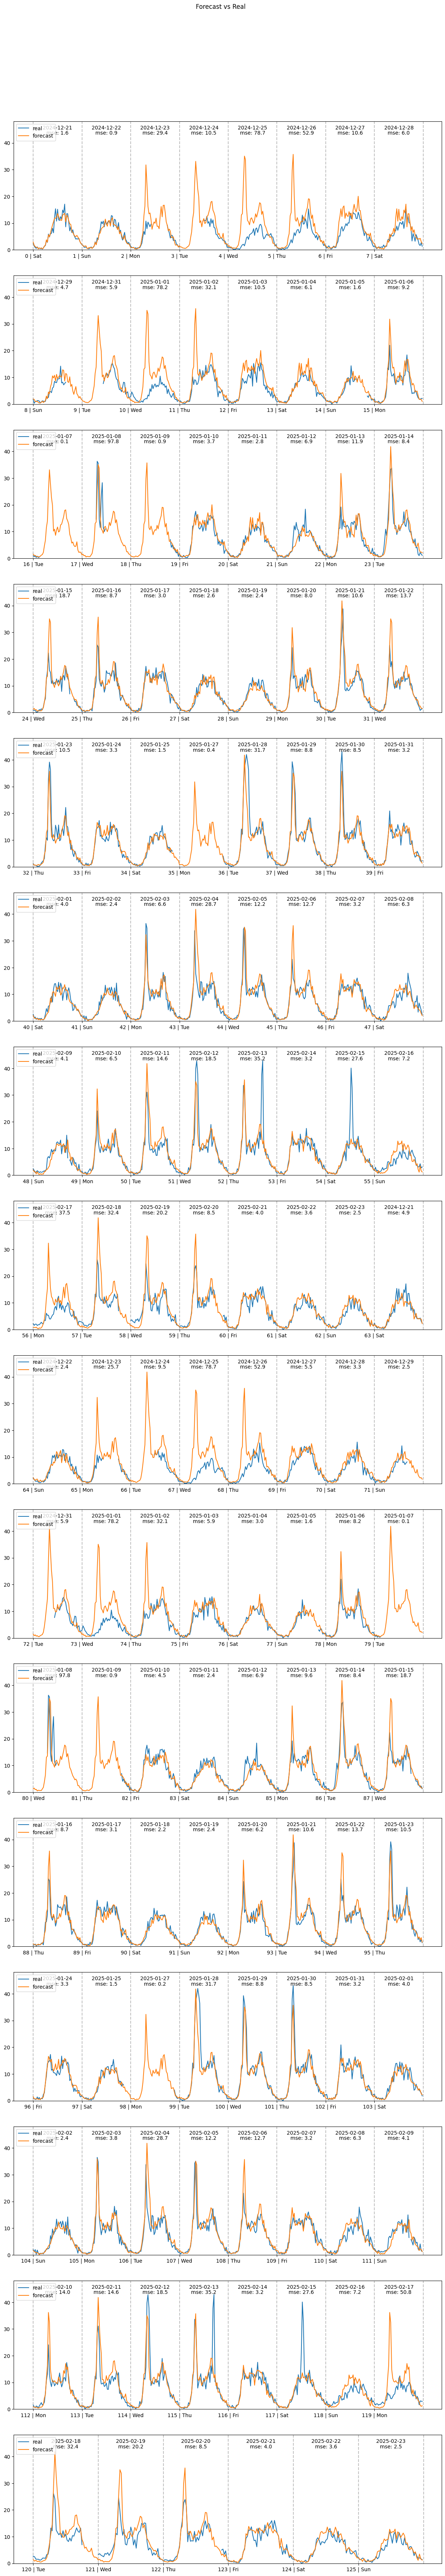

In [8]:
df_plot = pd.read_csv(plot_csv_path, index_col='time')
df_plot.index = pd.to_datetime(df_plot.index)
dates = [time.strftime('%Y-%m-%d') for time in df_plot.index]
X = df_plot[['num_cars', 'day_of_week']].values
forecast = df_plot['forecast'].values

plot_all_day = ForecastAllDayPlotter(n_days_in_row=8)
fig = plot_all_day.plot(X, forecast, dates)